In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Converting the MNIST datset into a tensor of 4D (no. of images, height, width, color channels)
transform = transforms.ToTensor()

In [ ]:
#Get the training data
train_data = datasets.MNIST(root='/cnn_mnist_data', train=True, download=True, transform=transform)

In [4]:
#test data
test_data = datasets.MNIST(root='/cnn_mnist_data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_mnist_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
#creating small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [7]:
#define our CNN model
#What it is doing, we will have two convolutional layers
#The 4 arguments to be passeed in Conv2D are input (eg 1 image), output(we want 6 feature out puts), kernel/filter size (3X3 matrix), stride
conv1 = nn.Conv2d(1, 6, 3, 1) 
conv2 = nn.Conv2d(6, 16, 3, 1)

In [8]:
#grab one MNIST Record/Image
for i, (X_Train, y_train) in enumerate(train_data):
    break
X_Train.shape
#this is the size of mnist data set, first index is image number and the other two are the image size (28x28 images)

torch.Size([1, 28, 28])

In [9]:
#We want to make it 4D, the first index will be of batch size then the no of image then the size of image
x = X_Train.view(1, 1, 28, 28)

In [10]:
#Performing the first convolution
x = F.relu(conv1(x)) #Rectified Linear Unit
x.shape
#The 1 is the Image and 6 is the filters we asked for 26x26 is the resultant convoluted image, losing the 2 size as we did not set padding

torch.Size([1, 6, 26, 26])

In [11]:
#Passing x through a pooling layer
x = F.max_pool2d(x,2,2) #the filter size is 2 and the stride is 2 as well
x.shape
#26/2 is 13

torch.Size([1, 6, 13, 13])

In [12]:
#Do our second convolutional layer
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [13]:
#lets do our second pooling layer
x = F.max_pool2d(x, 2, 2)
x.shape
#11/2 = 5.5 we round down as we can not round up and create data, so we delete it

torch.Size([1, 16, 5, 5])

In [14]:
#Model Class
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # Fully connected Layer
        self.fc1 = nn.Linear(5*5*16, 120) # 5*5*16 as that is the output of 2 convolution and teo poolong layers
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        # First Pass
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        # Second Pass
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        # Re-view to flatten it out
        X = X.view(-1, 16*5*5)  # -1 so we can vary the batch size 

        # Fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [15]:
# Create an Instance for our Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
# Loss Function  Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
# the smaller the lR the longer it will take

In [17]:
import time
start_time = time.time()

#Create Variables to track things
epochs = 5
train_loss = []
test_loss = []
train_correct = []
test_correct = []

# For loop for epochs
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Train
    
    for b, (X_train, y_train) in enumerate(train_loader):
        
        b += 1 # Start our batch at one
        y_pred = model(X_train) # Get pred value from train set, not flattened 2D
        loss = criterion(y_pred, y_train) # How off are we from our prediction through cross entropy loss

        predicted = torch.max(y_pred.data, 1)[1] # Add up the number of correct predictions. Indexed off the first point
        batch_corr = (predicted == y_train).sum() # How many we got correct from this batch
        trn_corr += batch_corr
        
        # Update parameters BACKPROP
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print out some results
        if b%600 == 0:
            print(f'Epoch: {i} Batch: {b}  Loss: {loss.item()}')

    train_loss.append(loss)
    train_correct.append(trn_corr) 

    # Test
    with torch.no_grad():

        for b, (X_test, y_test) in enumerate(test_loader):

            b+= 1
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1] #STILL DO NOT COMPLETELY UNDERSTAND THIS (Taking the max out of the 10 output values and just taking the index??)
            tst_corr += (predicted == y_test).sum()

        loss = criterion(y_val, y_test)
        test_loss.append(loss)
        test_correct.append(tst_corr)

current_time = time.time()
total_time = current_time - start_time
print(f'Training took: {total_time/60} minutes!')

Epoch: 0 Batch: 600  Loss: 0.16885995864868164
Epoch: 0 Batch: 1200  Loss: 0.16938352584838867
Epoch: 0 Batch: 1800  Loss: 0.4754141867160797
Epoch: 0 Batch: 2400  Loss: 0.14266805350780487
Epoch: 0 Batch: 3000  Loss: 0.010450301691889763
Epoch: 0 Batch: 3600  Loss: 0.42014971375465393
Epoch: 0 Batch: 4200  Loss: 0.0024467159528285265
Epoch: 0 Batch: 4800  Loss: 0.002136596478521824
Epoch: 0 Batch: 5400  Loss: 0.030971873551607132
Epoch: 0 Batch: 6000  Loss: 0.0006094513810239732
Epoch: 1 Batch: 600  Loss: 0.004319391213357449
Epoch: 1 Batch: 1200  Loss: 0.22070904076099396
Epoch: 1 Batch: 1800  Loss: 0.0039879800751805305
Epoch: 1 Batch: 2400  Loss: 0.004662370774894953
Epoch: 1 Batch: 3000  Loss: 0.016432903707027435
Epoch: 1 Batch: 3600  Loss: 0.4476250112056732
Epoch: 1 Batch: 4200  Loss: 0.027203183621168137
Epoch: 1 Batch: 4800  Loss: 0.00029392814030870795
Epoch: 1 Batch: 5400  Loss: 0.0004991074674762785
Epoch: 1 Batch: 6000  Loss: 0.44433921575546265
Epoch: 2 Batch: 600  Loss:

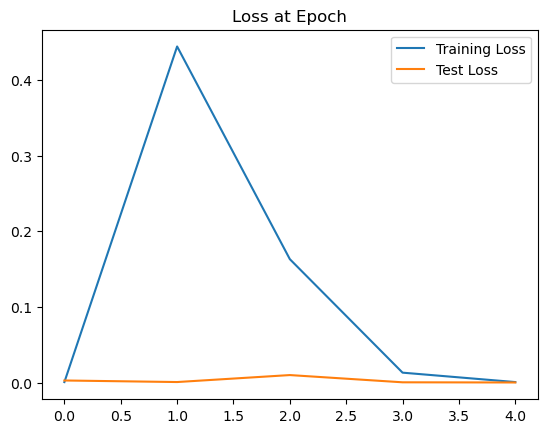

In [61]:
# Graph the epoch vs loss graph
#train_loss = [tl.item() for tl in train_loss]
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss at Epoch')
plt.legend()
plt.show()

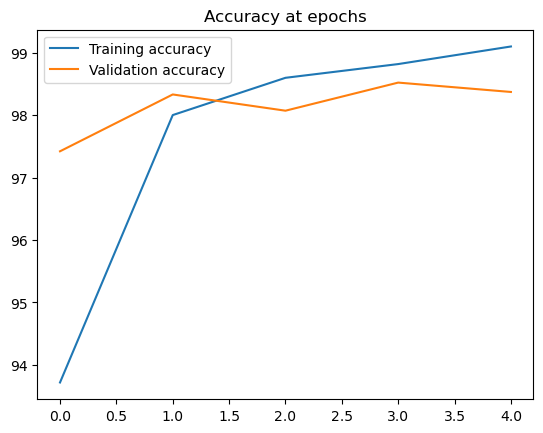

In [40]:
#Plot the accuracy
plt.plot([t/600 for t in train_correct], label='Training accuracy')
plt.plot([t/100 for t in test_correct], label='Validation accuracy')
plt.title('Accuracy at epochs')
plt.legend()
plt.show()

In [41]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()
#Printing fow many we got correct
percent = (correct/len(test_data))*100
print(f'Out of {len(test_data)} test data set we got {correct} correct which gives us an accuracy of {float("%.2f"%percent)}%')

Out of 10000 test data set we got 9837 correct which gives us an accuracy of 98.37%


In [6]:
# grab a random image out of our test data 
import random
rand = random.randint(1, 10000)
plt.imshow(test_data[rand][0].reshape(28,28))
plt.show()

NameError: name 'test_data' is not defined

In [146]:
#Lets test the image
print(test_data[rand][0].dtype)
with torch.no_grad():
    new_pred = model(test_data[rand][0].reshape(1, 1, 28,28)) # As we pass a 4D tensor through our CNN
pred_num = new_pred.argmax().item()
print(f'The model prediction of the above image is {pred_num} and the image is labeled as {test_data[rand][1]}')

torch.float32
The model prediction of the above image is 1 and the image is labeled as 1


torch.float32 torch.Size([1, 28, 28])


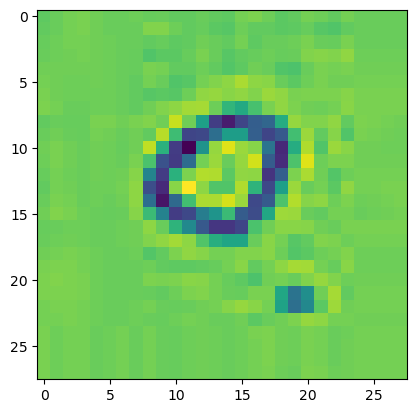

In [116]:
# Converting the image i took into tensor
from PIL import Image
import torchvision.transforms as transforms

# Read a PIL Image
image = Image.open('test image 0 28.jpg')
image = transforms.functional.to_grayscale(image, num_output_channels=1)
# Define a transform to convert PIL 
# image to a Torch tensor
#transform = transforms.Compose([
    #transforms.functional.to_tensor()
#])

# transform = transforms.PILToTensor()
# Convert the PIL image to Torch tensor
img_tensor = transforms.functional.to_tensor(image)

# print the converted Torch tensor
print(img_tensor.dtype, img_tensor.size())

plt.imshow(img_tensor.detach().numpy().T)
plt.show()

In [148]:
img = img_tensor.reshape(1, 1, 28,28)
with torch.no_grad():
    new_pred = model(img) # As we pass a 4D tensor through our CNN
pred_num = new_pred.argmax().item()
print(f'The model prediction of the above image is {pred_num}')
#print(new_pred)

The model prediction of the above image is 9
